# Load

In [1]:
source("~/public/SiyuanLuo/projects/benchmark/scripts/evaluation/lib_metrics.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/clustering/lib_clustering.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/func_aggregation.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/func_signac.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/feature_engineering.R", chdir=TRUE)
source("~/public/SiyuanLuo/projects/benchmark/scripts/analysis/utils.R", chdir=TRUE)


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis




In [2]:
suppressPackageStartupMessages({
    devtools::load_all(path="~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/scFeatAgg")
    # devtools::reload(pkg ="~/public/SiyuanLuo/projects/benchmark/scripts/feature_engineering/scFeatAgg", quiet = FALSE)
    require(Signac)
    require(Seurat)
    require(SingleCellExperiment)
    require(mbkmeans)
    library(tidyr)
    library(scran)
})


ℹ Loading scFeatAgg


In [3]:
dataset_ls <- c("Buenrostro_2018", "candidate1", "Cell_line_mixing", "Chen_2019",  "PBMC_multiomics", "candidate2") #"Ma_2019",
k_ls <- c(9, 13, 10, 13, 15, 10)

In [ ]:
# get fantom5 enhancer bed file
# wget https://fantom.gsc.riken.jp/5/datafiles/reprocessed/hg38_latest/extra/enhancer/F5.hg38.enhancers.bed.gz

In [18]:
library(rtracklayer)
enhancer_obj <-  import("F5.hg38.enhancers.bed.gz", format = "BED")

# candidate1

In [6]:
j <- 2
dataset <- dataset_ls[j]
k_optimal <- k_ls[j]

In [4]:
output_dir <- "/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/features/candidate1/"
frag_path <- "/home/siluo/public/SiyuanLuo/projects/benchmark/raw_data/candidate1/pooled_fragments_sorted.bed.gz"

In [8]:
frags <- Signac::CreateFragmentObject(path = frag_path)
# Quantify features
counts <- FeatureMatrix(
    fragments = frags,
    features = enhancer_obj
)

Computing hash

Extracting reads overlapping genomic regions



In [9]:
dim(counts)

[1] 63285 20204

In [12]:
genome <- "hg38"
assay_type <- "enhancer"
embed_name <- paste0("lsi_",assay_type)
annotation_list <- list("hg19" = "UCSC_annotation_hg19.rds",
                "hg38" = "UCSC_annotation_hg38.rds",
                "mm10" = "UCSC_annotation_mm10.rds")
annotation <- readRDS(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/database/annotation/", annotation_list[[genome]]))

In [13]:
# Create Seurat object
assay <- CreateChromatinAssay(counts,
                            fragments = frags,
                            genome = genome,
                            annotation = annotation)
sobj <- CreateSeuratObject(assay, assay = assay_type)
DefaultAssay(sobj) <- assay_type

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from enhancer to enhancer_”


In [14]:
sobj <- RunTFIDF(sobj,
                assay = assay_type,
                method = 1)  # computes log(TF×IDF)
sobj <- FindTopFeatures(sobj,
                min.cutoff = 10,
                assay = assay_type)
sobj

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”


An object of class Seurat 
63285 features across 20204 samples within 1 assay 
Active assay: enhancer (63285 features, 39586 variable features)

In [16]:
sobj <- RunSVD(sobj,
            n = 100,
            assay = assay_type,
            reduction.key = "LSI_",
            reduction.name = embed_name)

Running SVD

Scaling cell embeddings



In [35]:
mobj <- getFeatureMatrixSignac(sobj,
								embedding_name=embed_name,
								assay = assay_type,
								corCutOff = 0.75,
								n = 100)

In [36]:
# quickly check the UMAP
label_table_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/raw_data/candidate1/cell_type_annotation.tsv"
barcode_col <- "long_barcode"
label_col <- "cell_type"
sobj <- add_labels(sobj, label_table_file, barcode_col, label_col)
ndim <- 100


name1 <- paste0("nn_ndim", ndim)
name2 <- paste0("snn_ndim", ndim)
sobj <- FindNeighbors(object = sobj, 
                        reduction = embed_name, 
                        graph.name = c(paste0("nn_ndim", ndim), paste0("snn_ndim", ndim))
                    )
sobj@graphs[[name1]] <- as.Graph(sobj@graphs[[name1]])
sobj@graphs[[name2]] <- as.Graph(sobj@graphs[[name2]])

ndim0 <- dim(sobj@reductions[[embed_name]])[2]
sobj <- RunUMAP(sobj, 
        reduction = embed_name,
        dims = 1:ndim0)

Computing nearest neighbor graph

Computing SNN

13:58:11 UMAP embedding parameters a = 0.9922 b = 1.112

13:58:11 Read 20204 rows and found 100 numeric columns

13:58:11 Using Annoy for neighbor search, n_neighbors = 30

13:58:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:58:14 Writing NN index file to temp file /media/siluo/c55ed6ce-672c-4a68-b60e-cef07edf5933/scratch/RtmpLzfwuQ/file2c4ff78b863b0

13:58:14 Searching Annoy index using 1 thread, search_k = 3000

13:58:25 Annoy recall = 100%

13:58:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:58:29 Initializing from normalized Laplacian + noise (using irlba)

13:58:29 Commencing optimization for 200 epochs, with 781766 positive edges

13:58:37 Optimization finish

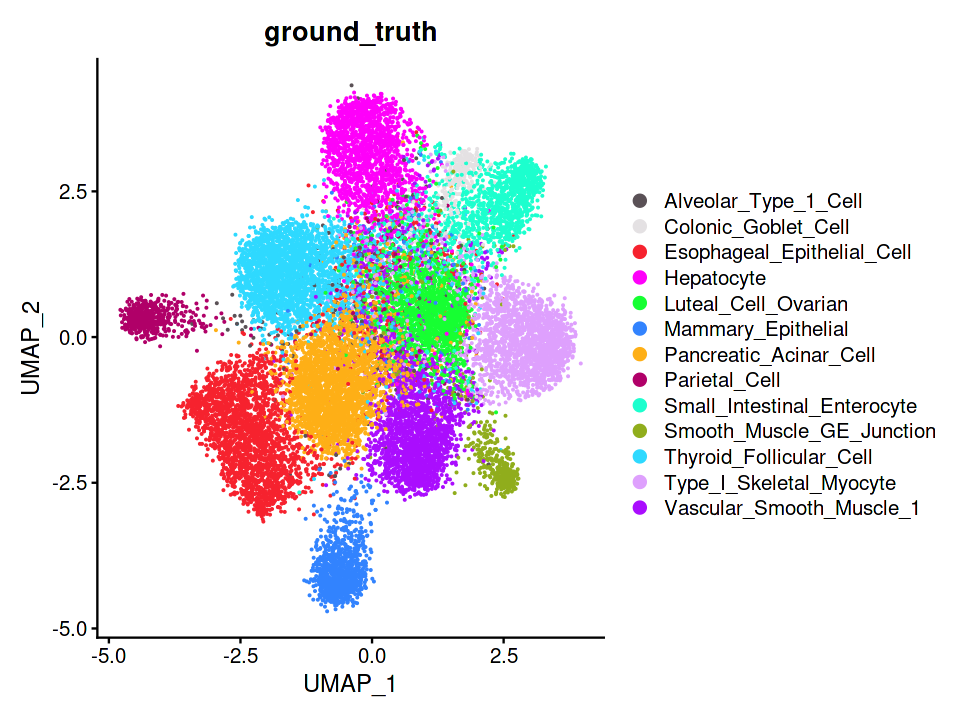

In [37]:
options(repr.plot.width=8, repr.plot.height=6)
DimPlot(sobj, reduction = "umap", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

In [22]:
saveRDS(sobj, paste0(output_dir, "Signac_enhancer.RDS"))
saveFeatureMatrix(mobj, paste0(output_dir, "Signac_enhancer_100.tsv"))

In [23]:
feature_matrix <- GetAssayData(sobj[[assay_type]], slot = "counts") # feature-by-cell matrix!
feature_matrix <- t(feature_matrix)
dims=seq(2L, 12L)
n_meta_features=1000
n_cells=2000 
norm_method='tfidf' 
reduce="pca"
ndim=100
norm_function <- Signac::RunTFIDF

embed <- aggregate_features(feature_matrix=feature_matrix, dims=dims, n_meta_features=n_meta_features, n_cells=n_cells, norm_function=norm_function, reduce=reduce, sce=NULL)
counts <- Matrix::rowSums(feature_matrix)
embed <- embed[, seq_len(length.out = ndim)]
components <- DepthCorComponents(embed, counts, 0.75, ndim)
agg_feature_matrix <- embed[, components]

Loading required package: scDblFinder


Attaching package: ‘scDblFinder’


The following objects are masked from ‘package:scFeatAgg’:

    aggregateFeatures, TFIDF


Performing TF-IDF normalization

Second iteration...

Performing TF-IDF normalization



In [24]:
saveFeatureMatrix(agg_feature_matrix, paste0(output_dir,"Enhancer_Agg_100.tsv"))

In [40]:
sobj_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/candidate1/candidate1/clustering/Signac/by_cluster_peaks/0/default/15/sobj_SNN.RDS"
sobj <- readRDS(sobj_file)

sobj <- add_embedding(sobj, paste0(output_dir,"Signac_enhancer_100.tsv"), embed_name="enhancer.signac")
sobj <- add_embedding(sobj, paste0(output_dir,"Enhancer_Agg_100.tsv"), embed_name="enhancer.agg")


Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:99'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:100'”


In [41]:
saveRDS(sobj, paste0(output_dir,"candidate1_sobj_ndim100.RDS"))

In [5]:
sobj <- readRDS(paste0(output_dir,"candidate1_sobj_ndim100.RDS"))

In [7]:
# options(warn=-1)
embed_ls <- c("enhancer.signac", "enhancer.agg")

# r_ls <- c(0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4)
r_ls <- c(0.25)

for(embed_name in embed_ls){
    print(embed_name)
    name1 <- paste0("nn_", embed_name)
    name2 <- paste0("snn_", embed_name)
    sobj <- FindNeighbors(object = sobj, 
                            reduction = embed_name, 
                            graph.name = c(name1, name2),
                            verbose = FALSE
                        )
    # sobj@graphs[[name1]] <- as.Graph(sobj@graphs[[name1]])
    # sobj@graphs[[name2]] <- as.Graph(sobj@graphs[[name2]])
    # ndim0 <- dim(sobj@reductions[[embed_name]])[2]
    # sobj <- RunUMAP(sobj, 
    #         reduction = embed_name,
    #         dims = 1:ndim0,
    #         reduction.name=paste0("umap_" ,embed_name),
    #         verbose = FALSE)
    for(r in r_ls){
        print(r)
        sobj <- FindClusters(object = sobj, 
                    verbose = FALSE, 
                    algorithm = 4,
                    resolution = r,
                    graph.name = name2
                    )
        sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj$seurat_clusters
        gc()
    }
}

saveRDS(sobj, paste0(output_dir,"candidate1_sobj_ndim100_clustering.RDS"))

[1] "enhancer.signac"
[1] 0.25


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to integer range”
Warning message in paste("reticulate", module, "load", sep = "::"):
“NAs introduced by coercion to intege

[1] "enhancer.agg"
[1] 0.25


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.0 GiB”


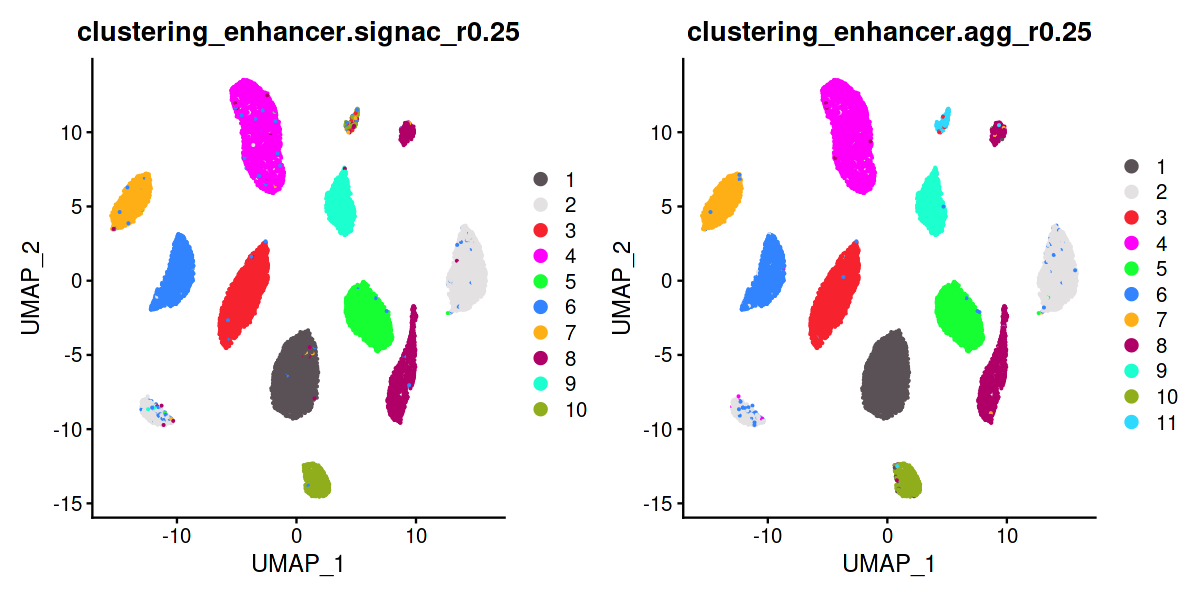

In [10]:
options(repr.plot.width=10, repr.plot.height=5)
p1 <- DimPlot(sobj, reduction = "umap", label = F, repel=T, 
        group.by = "clustering_enhancer.signac_r0.25", cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 
p2 <- DimPlot(sobj, reduction = "umap", label = F, repel=T, 
        group.by = "clustering_enhancer.agg_r0.25", cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 
        p1 + p2

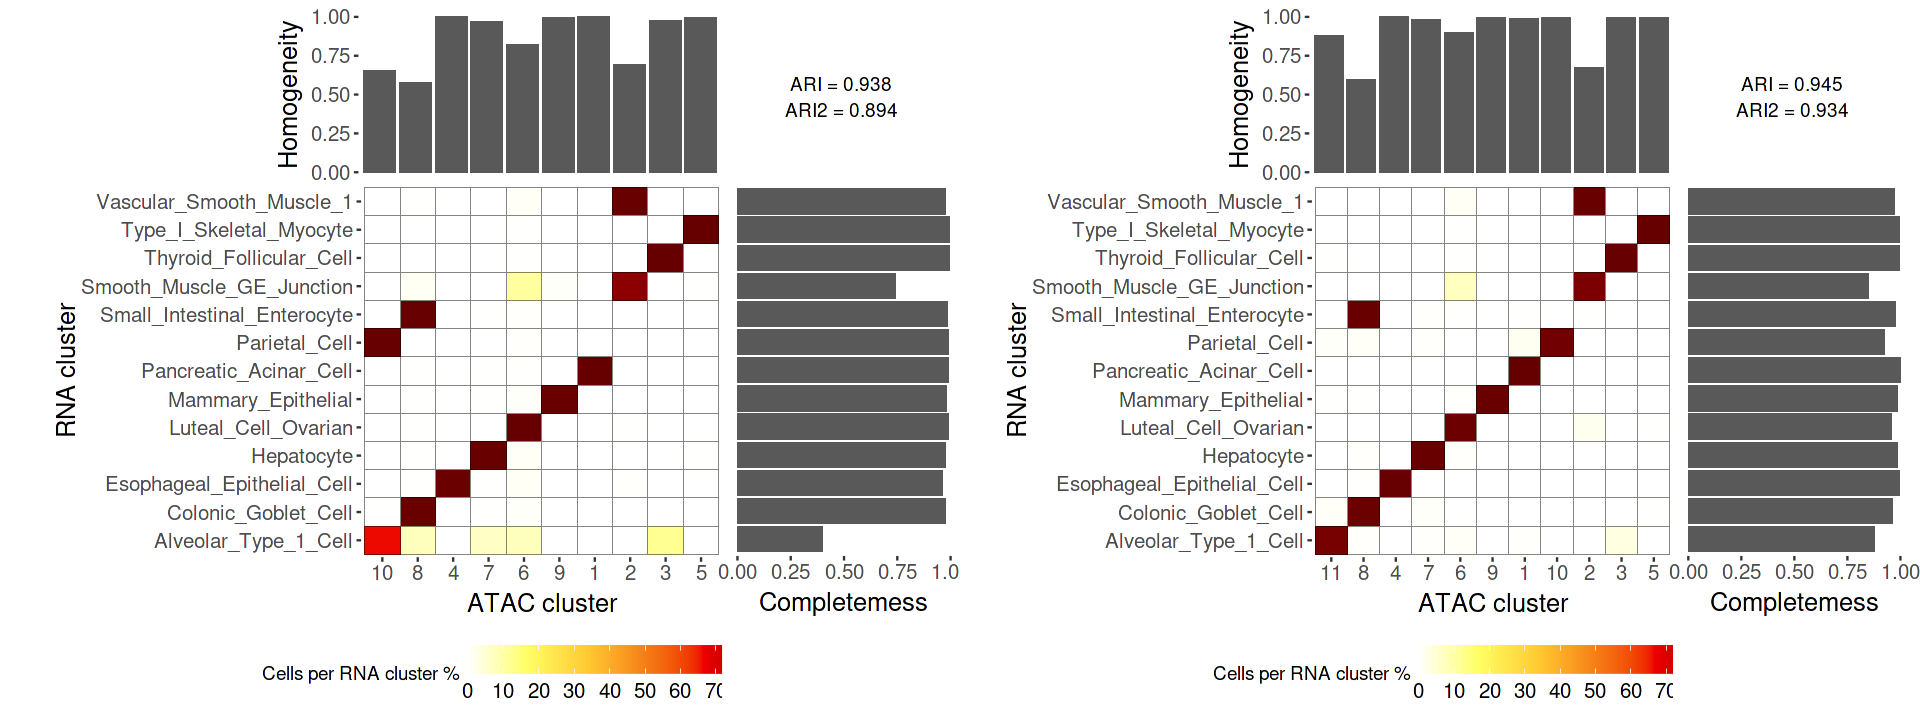

In [14]:
options(repr.plot.width=16, repr.plot.height=6)
ground_truth <- sobj$ground_truth
clusterings <- sobj@meta.data[["clustering_enhancer.signac_r0.25"]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
clusterings <- sobj@meta.data[["clustering_enhancer.agg_r0.25"]]
p2 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p1 + p2

# PBMC

In [15]:
j <- 5
dataset <- dataset_ls[j]
k_optimal <- k_ls[j]

In [16]:
output_dir <- "/home/siluo/public/SiyuanLuo/projects/benchmark/scripts/analysis/features/PBMC_multiomics/"
frag_path <- "/home/siluo/public/SiyuanLuo/projects/benchmark/cleaned_data/PBMC_multiomics/pbmc_granulocyte_sorted_10k_atac_fragments.filtered.sorted.tsv.gz"

In [19]:
frags <- Signac::CreateFragmentObject(path = frag_path)
# Quantify features
counts <- FeatureMatrix(
    fragments = frags,
    features = enhancer_obj
)

Computing hash

Extracting reads overlapping genomic regions



In [21]:
dim(counts)

[1] 63285  8560

In [22]:
genome <- "hg38"
assay_type <- "enhancer"
embed_name <- paste0("lsi_",assay_type)
annotation_list <- list("hg19" = "UCSC_annotation_hg19.rds",
                "hg38" = "UCSC_annotation_hg38.rds",
                "mm10" = "UCSC_annotation_mm10.rds")
annotation <- readRDS(paste0("/home/siluo/public/SiyuanLuo/projects/benchmark/database/annotation/", annotation_list[[genome]]))

In [23]:
# Create Seurat object
assay <- CreateChromatinAssay(counts,
                            fragments = frags,
                            genome = genome,
                            annotation = annotation)
sobj <- CreateSeuratObject(assay, assay = assay_type)
DefaultAssay(sobj) <- assay_type

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from enhancer to enhancer_”


In [24]:
sobj <- RunTFIDF(sobj,
                assay = assay_type,
                method = 1)  # computes log(TF×IDF)
sobj <- FindTopFeatures(sobj,
                min.cutoff = 10,
                assay = assay_type)
sobj

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”


An object of class Seurat 
63285 features across 8560 samples within 1 assay 
Active assay: enhancer (63285 features, 38903 variable features)

In [25]:
sobj <- RunSVD(sobj,
            n = 100,
            assay = assay_type,
            reduction.key = "LSI_",
            reduction.name = embed_name)

Running SVD

Scaling cell embeddings



In [26]:
mobj <- getFeatureMatrixSignac(sobj,
								embedding_name=embed_name,
								assay = assay_type,
								corCutOff = 0.75,
								n = 100)

In [27]:
# quickly check the UMAP
label_table_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/cleaned_data/PBMC_multiomics/PBMC_multiomics_RNA_annotation.txt"
barcode_col <- "rna_barcode"
label_col <- "final_label"
sobj <- add_labels(sobj, label_table_file, barcode_col, label_col)
ndim <- 100


name1 <- paste0("nn_ndim", ndim)
name2 <- paste0("snn_ndim", ndim)
sobj <- FindNeighbors(object = sobj, 
                        reduction = embed_name, 
                        graph.name = c(paste0("nn_ndim", ndim), paste0("snn_ndim", ndim))
                    )
sobj@graphs[[name1]] <- as.Graph(sobj@graphs[[name1]])
sobj@graphs[[name2]] <- as.Graph(sobj@graphs[[name2]])

ndim0 <- dim(sobj@reductions[[embed_name]])[2]
sobj <- RunUMAP(sobj, 
        reduction = embed_name,
        dims = 1:ndim0)

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:34:50 UMAP embedding parameters a = 0.9922 b = 1.112

14:34:50 Read 8560 rows and found 100 numeric columns

14:34:50 Using Annoy for neighbor search, n_neighbors = 30

14:34:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:34:51 Writing NN index file to temp file /media/siluo/c55ed6ce-672c-4a68-b60e-cef07edf5933/scratch/RtmpbAf3eS/file2e2fc2669765f

14:34:51 Searching Annoy index using 1 thread, search_k = 3000

14:34:54 Annoy reca

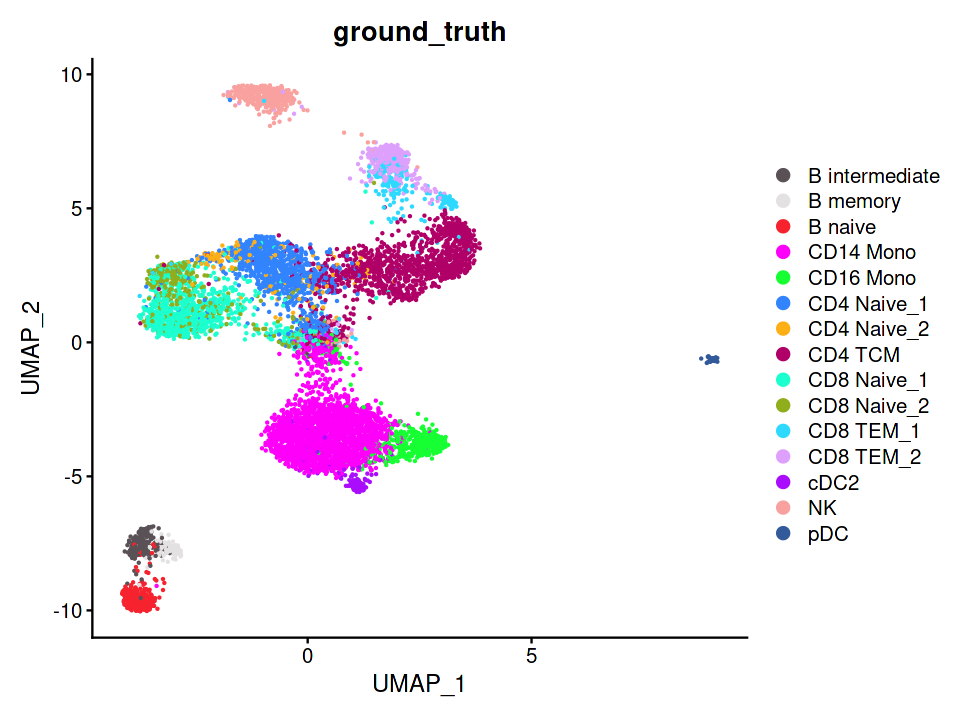

In [28]:
options(repr.plot.width=8, repr.plot.height=6)
DimPlot(sobj, reduction = "umap", label = F, repel=T, 
        group.by = "ground_truth", cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

In [29]:
saveRDS(sobj, paste0(output_dir, "Signac_enhancer.RDS"))
saveFeatureMatrix(mobj, paste0(output_dir, "Signac_enhancer_100.tsv"))

In [30]:
feature_matrix <- GetAssayData(sobj[[assay_type]], slot = "counts") # feature-by-cell matrix!
feature_matrix <- t(feature_matrix)
dims=seq(2L, 12L)
n_meta_features=1000
n_cells=2000 
norm_method='tfidf' 
reduce="pca"
ndim=100
norm_function <- Signac::RunTFIDF

embed <- aggregate_features(feature_matrix=feature_matrix, dims=dims, n_meta_features=n_meta_features, n_cells=n_cells, norm_function=norm_function, reduce=reduce, sce=NULL)
counts <- Matrix::rowSums(feature_matrix)
embed <- embed[, seq_len(length.out = ndim)]
components <- DepthCorComponents(embed, counts, 0.75, ndim)
agg_feature_matrix <- embed[, components]

Loading required package: scDblFinder


Attaching package: ‘scDblFinder’


The following objects are masked from ‘package:scFeatAgg’:

    aggregateFeatures, TFIDF


Performing TF-IDF normalization

Second iteration...

Performing TF-IDF normalization



In [31]:
saveFeatureMatrix(agg_feature_matrix, paste0(output_dir,"Enhancer_Agg_100.tsv"))

In [32]:
sobj_file <- "/home/siluo/public/SiyuanLuo/projects/benchmark/outputs/PBMC_multiomics/PBMC_multiomics/clustering/Signac/by_cluster_peaks/0/default/15/sobj_SNN.RDS"
sobj <- readRDS(sobj_file)

sobj <- add_embedding(sobj, paste0(output_dir,"Signac_enhancer_100.tsv"), embed_name="enhancer.signac")
sobj <- add_embedding(sobj, paste0(output_dir,"Enhancer_Agg_100.tsv"), embed_name="enhancer.agg")


Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:99'”
Warning message:
“No columnames present in cell embeddings, setting to 'LSI_1:100'”


In [33]:
saveRDS(sobj, paste0(output_dir,"PBMC_multiomics_sobj_ndim100.RDS"))

In [ ]:
sobj <- readRDS(paste0(output_dir,"PBMC_multiomics_sobj_ndim100.RDS"))

In [38]:
# options(warn=-1)
embed_ls <- c("enhancer.signac", "enhancer.agg")

# r_ls <- c(0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4)
r_ls <- c(0.1, 0.2, 0.25, 0.3, 0.4)

for(embed_name in embed_ls){
    print(embed_name)
    name1 <- paste0("nn_", embed_name)
    name2 <- paste0("snn_", embed_name)
    sobj <- FindNeighbors(object = sobj, 
                            reduction = embed_name, 
                            graph.name = c(name1, name2),
                            verbose = FALSE
                        )
    # sobj@graphs[[name1]] <- as.Graph(sobj@graphs[[name1]])
    # sobj@graphs[[name2]] <- as.Graph(sobj@graphs[[name2]])
    # ndim0 <- dim(sobj@reductions[[embed_name]])[2]
    # sobj <- RunUMAP(sobj, 
    #         reduction = embed_name,
    #         dims = 1:ndim0,
    #         reduction.name=paste0("umap_" ,embed_name),
    #         verbose = FALSE)
    for(r in r_ls){
        print(r)
        sobj <- FindClusters(object = sobj, 
                    verbose = FALSE, 
                    algorithm = 4,
                    resolution = r,
                    graph.name = name2
                    )
        sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]] <- sobj$seurat_clusters
        gc()
    }
}

saveRDS(sobj, paste0(output_dir,"PBMC_multiomics_sobj_ndim100_clustering.RDS"))

[1] "enhancer.signac"
[1] 0.1
[1] 0.2
[1] 0.3
[1] 0.4
[1] "enhancer.agg"
[1] 0.1
[1] 0.2
[1] 0.3
[1] 0.4


In [42]:
df <- data.frame(ARI=c(), resolution=c(), method=c(), n_cluster=c())
r_ls <- c(0.1, 0.2, 0.25, 0.3, 0.4)
embed_name <- embed_ls[1]
for(r in r_ls){
pred <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
ari <- aricode::ARI(sobj$ground_truth, pred)
# print(embed_name)
# print(ari)
# print(max(as.numeric(unique(pred))))
df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred)))))
}   

embed_name <- embed_ls[2]
for(r in r_ls){
pred <- sobj@meta.data[[paste0("clustering_" ,embed_name, "_r", r)]]
ari <- aricode::ARI(sobj$ground_truth, pred)
# print(embed_name)
# print(ari)
# print(max(as.numeric(unique(pred))))
df <- rbind(df, list(ARI=ari, resolution=r, method=embed_name, n_cluster=max(as.numeric(unique(pred)))))
}   


In [43]:
df

ARI,resolution,method,n_cluster
<dbl>,<dbl>,<chr>,<dbl>
0.6395759,0.10,enhancer.signac,6
0.7960032,0.20,enhancer.signac,9
0.8044468,0.25,enhancer.signac,9
0.6544464,0.30,enhancer.signac,11
0.6243932,0.40,enhancer.signac,12
0.6312178,0.10,enhancer.agg,9
0.6949133,0.20,enhancer.agg,11
0.6586511,0.25,enhancer.agg,11
0.6762138,0.30,enhancer.agg,13


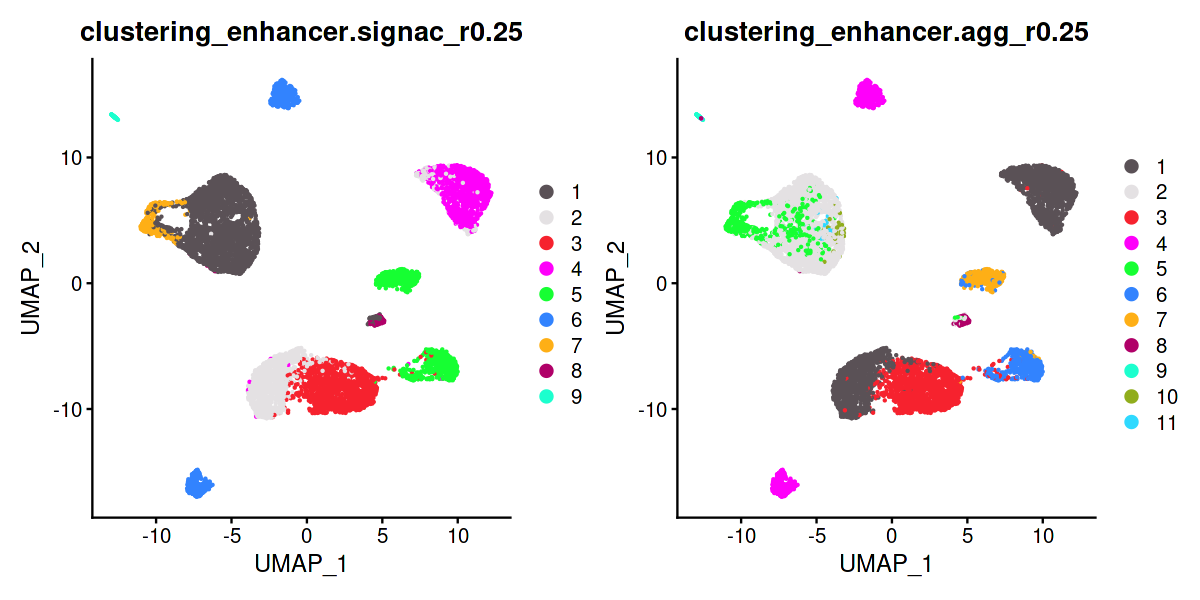

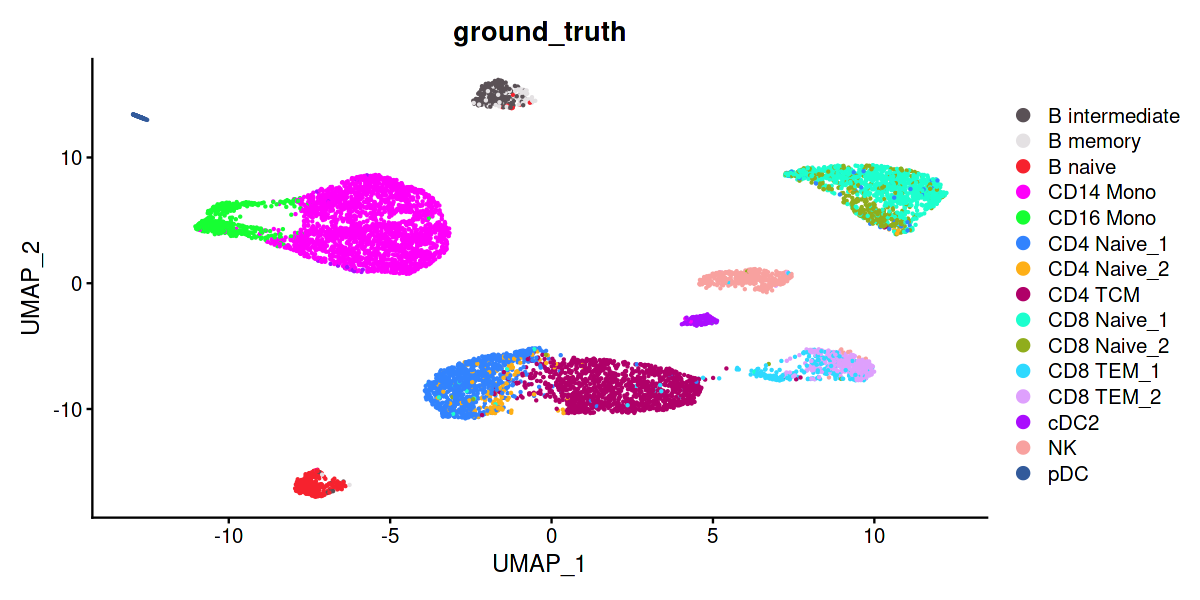

In [37]:
options(repr.plot.width=10, repr.plot.height=5)
p1 <- DimPlot(sobj, reduction = "umap", label = F, repel=T, 
        group.by = "clustering_enhancer.signac_r0.25", cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 
p2 <- DimPlot(sobj, reduction = "umap", label = F, repel=T, 
        group.by = "clustering_enhancer.agg_r0.25", cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 
p1 + p2
DimPlot(sobj, reduction = "umap", label = F, repel=T, 
group.by = "ground_truth", cols="polychrome") # + ggtitle(paste0(long_method,"_ndim",n, "_r", resolution)) 

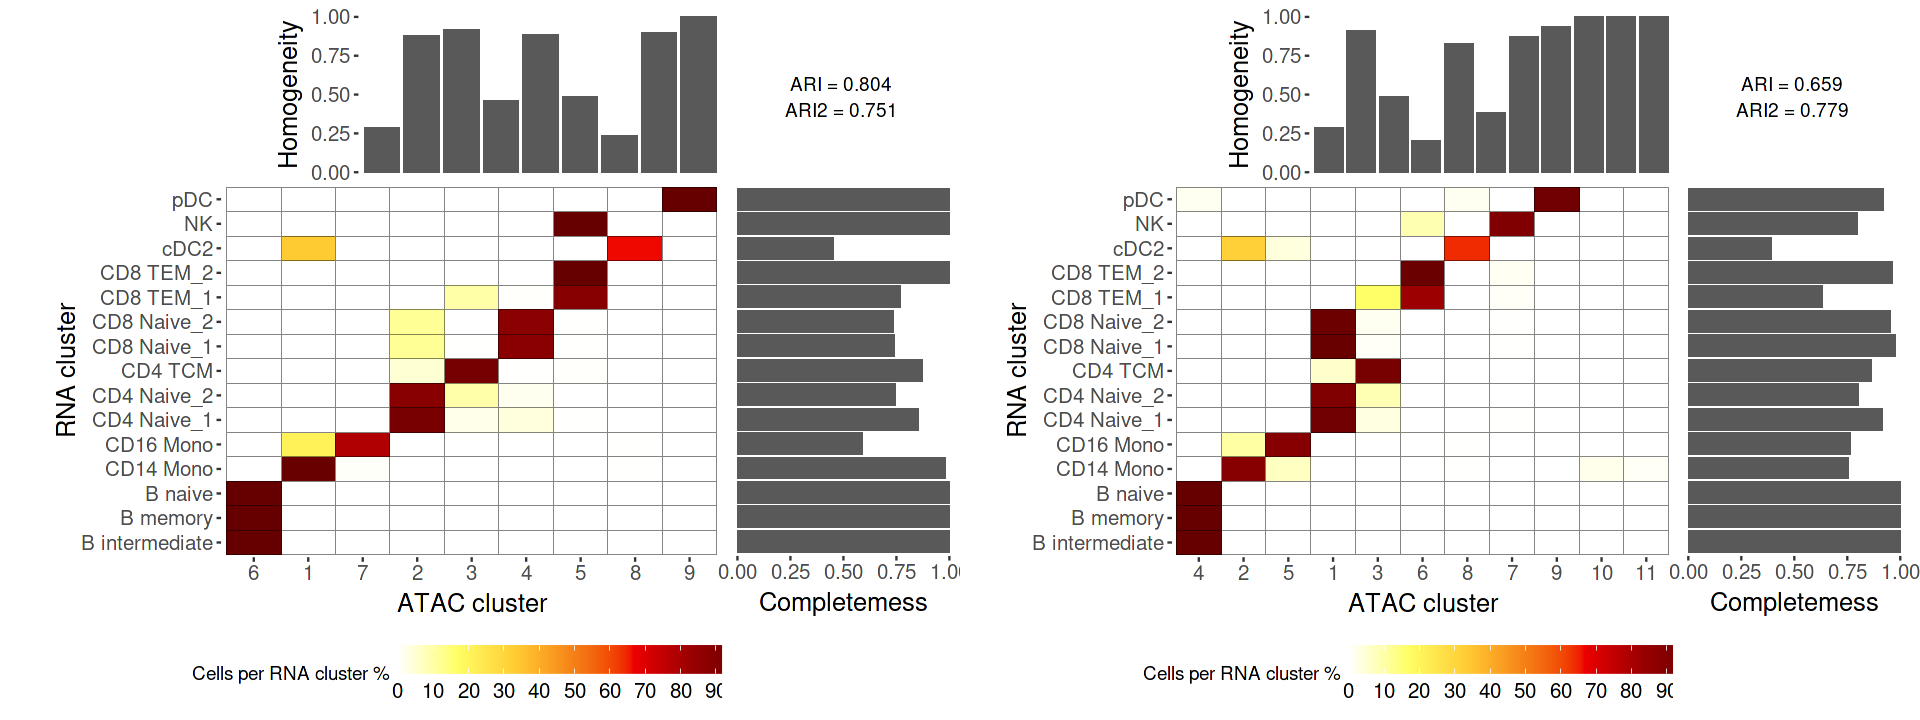

In [36]:
options(repr.plot.width=16, repr.plot.height=6)
ground_truth <- sobj$ground_truth
clusterings <- sobj@meta.data[["clustering_enhancer.signac_r0.25"]]
p1 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
clusterings <- sobj@meta.data[["clustering_enhancer.agg_r0.25"]]
p2 <- cross_table_plot(ground_truth, clusterings, a=1.5, b=5.7, c=2)
p1 + p2